# **House Prices - Advanced Regression Techniques**

本ノートブックでは、  
Kaggleコンペティション「**House Prices - Advanced Regression Techniques**」のデータセットを使用し、  
家の価格を予測する機械学習モデルの構築を行なっております。  
本ノートでは、  
前回のベースライン(RandomForestRegressor)から発展し、  
より高速かつ精度の高い学習が可能な **LightGBMRegressor** や、  
カテゴリ変数に強みを持つ **CatBoostRegressor** の勾配ブースティングモデルを採用し、  
前処理の改善や目的変数の変換などを組み合わせて精度向上を目指します。

### ◆ 前準備

#### モジュール・ライブラリの読み込み

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.0 MB/s eta 0:00:00


In [ ]:
# モジュール・ライブラリの読み込み
from pathlib import Path
from google.colab import files
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PowerTransformer

# from sklearn.ensemble import RandomForestRegressor

# import lightgbm as lgb
# from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor, Pool

# warningの非表示
import warnings
warnings.filterwarnings('ignore')
# dfの表示設定
pd.set_option('display.max_columns', None)

#### Pathの設定

In [ ]:
# Pathの設定
path = Path(".")
data_path = path / "data"
input_path = data_path / "input"
output_path = data_path / "output"

# フォルダの作成
input_path.mkdir(parents=True, exist_ok=True)
output_path.mkdir(parents=True, exist_ok=True)

#### データセットの読み込みと設定

In [ ]:
# kaggle.jsonのアップロード
files.upload()

In [ ]:
# kaggle.json用のフォルダ作成
!mkdir -p ~/.kaggle
# kaggle.jsonの移動
!cp kaggle.json ~/.kaggle/
# アクセス権限の許可
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# データセット.zipのダウンロード
!kaggle competitions download -c house-prices-advanced-regression-techniques -p {input_path}
# データセット.zipの展開
!unzip {input_path}/house-prices-advanced-regression-techniques.zip -d {input_path}
# データセット.zipの削除
!rm {input_path}/house-prices-advanced-regression-techniques.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 382MB/s]
Archive:  data/input/house-prices-advanced-regression-techniques.zip
  inflating: data/input/data_description.txt  
  inflating: data/input/sample_submission.csv  
  inflating: data/input/test.csv     
  inflating: data/input/train.csv    


In [ ]:
# csv fileのpathの取得
csv_list = sorted(glob(f"{input_path}/*.csv"))

# csv fileの読み込み
train = pd.read_csv(csv_list[2])
test = pd.read_csv(csv_list[1])
submission = pd.read_csv(csv_list[0])

csv_list

['data/input/sample_submission.csv',
 'data/input/test.csv',
 'data/input/train.csv']

### ◆ データの確認

In [ ]:
# 要素数の確認
print(train.shape)
print(test.shape)
print(submission.shape)

(1460, 81)
(1459, 80)
(1459, 2)


In [ ]:
# train の確認
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [ ]:
# test の確認
test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [ ]:
# train と test の結合
df = pd.concat([train, test], sort=False)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [ ]:
# dfの要素数の確認
df.shape

(2919, 81)

In [ ]:
# 数値カラムの詳細の確認
df.describe(include=np.number)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [ ]:
# オブジェクトカラムの詳細の確認
df.describe(exclude=np.number)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,2915,2919,198,2919,2919,2917,2919,2919,2919,2919,2919,2919,2919,2919,2919,2918,2918,1153,2919,2919,2919,2838,2837,2837,2840,2839,2919,2919,2919,2918,2918,2917,1499,2762,2760,2760,2760,2919,10,571,105,2918,2919
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,2265,2907,120,1859,2622,2916,2133,2778,443,2511,2889,2425,1471,2310,2876,1025,1014,879,1798,2538,1308,1283,2606,1904,851,2493,2874,1493,2723,2671,1492,2717,744,1723,1230,2604,2654,2641,4,329,95,2525,2402


このNotebookでは詳細な特徴量の説明は省略しております。  
特徴量の説明はBaselineのNotebookを参照してください。

### ◆ データの前処理

In [ ]:
# カラムの設定
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

# 目的変数以外の数値カラム
num_features = [col for col in num_cols if col not in "SalePrice"]

#### 欠損値の処理

In [ ]:
# 数値カラムの欠損値の確認
df[num_cols].isnull().sum()

,0
Id,0
MSSubClass,0
LotFrontage,486
LotArea,0
OverallQual,0
OverallCond,0
YearBuilt,0
YearRemodAdd,0
MasVnrArea,23
BsmtFinSF1,1


In [ ]:
# オブジェクトカラムの欠損値の確認
df[cat_cols].isnull().sum()

,0
MSZoning,4
Street,0
Alley,2721
LotShape,0
LandContour,0
Utilities,2
LotConfig,0
LandSlope,0
Neighborhood,0
Condition1,0


In [ ]:
# 数値カラムの欠損値を平均で補完
for feature in num_features:
    df[feature] = df[feature].fillna(df[feature].mean())

In [ ]:
# 欠損の多いオブジェクトカラムの削除
drop_cat_cols = ["Alley", "MasVnrType", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]
df.drop(columns=drop_cat_cols, inplace=True)

# 削除後のオブジェクトカラムの設定
cat_cols = df.select_dtypes(exclude=np.number).columns

In [ ]:
# オブジェクトカラムの欠損値を最頻値で補完
for feature in cat_cols:
    df[feature] = df[feature].fillna(df[feature].mode()[0])

In [ ]:
# 数値カラムの欠損値の確認
df[num_cols].isnull().sum()

,0
Id,0
MSSubClass,0
LotFrontage,0
LotArea,0
OverallQual,0
OverallCond,0
YearBuilt,0
YearRemodAdd,0
MasVnrArea,0
BsmtFinSF1,0


In [ ]:
# オブジェクトカラムの欠損値の確認
df[cat_cols].isnull().sum()

,0
MSZoning,0
Street,0
LotShape,0
LandContour,0
Utilities,0
LotConfig,0
LandSlope,0
Neighborhood,0
Condition1,0
Condition2,0


In [ ]:
# 削除後の要素確認
df.shape

(2919, 75)

#### 特徴量の可視化

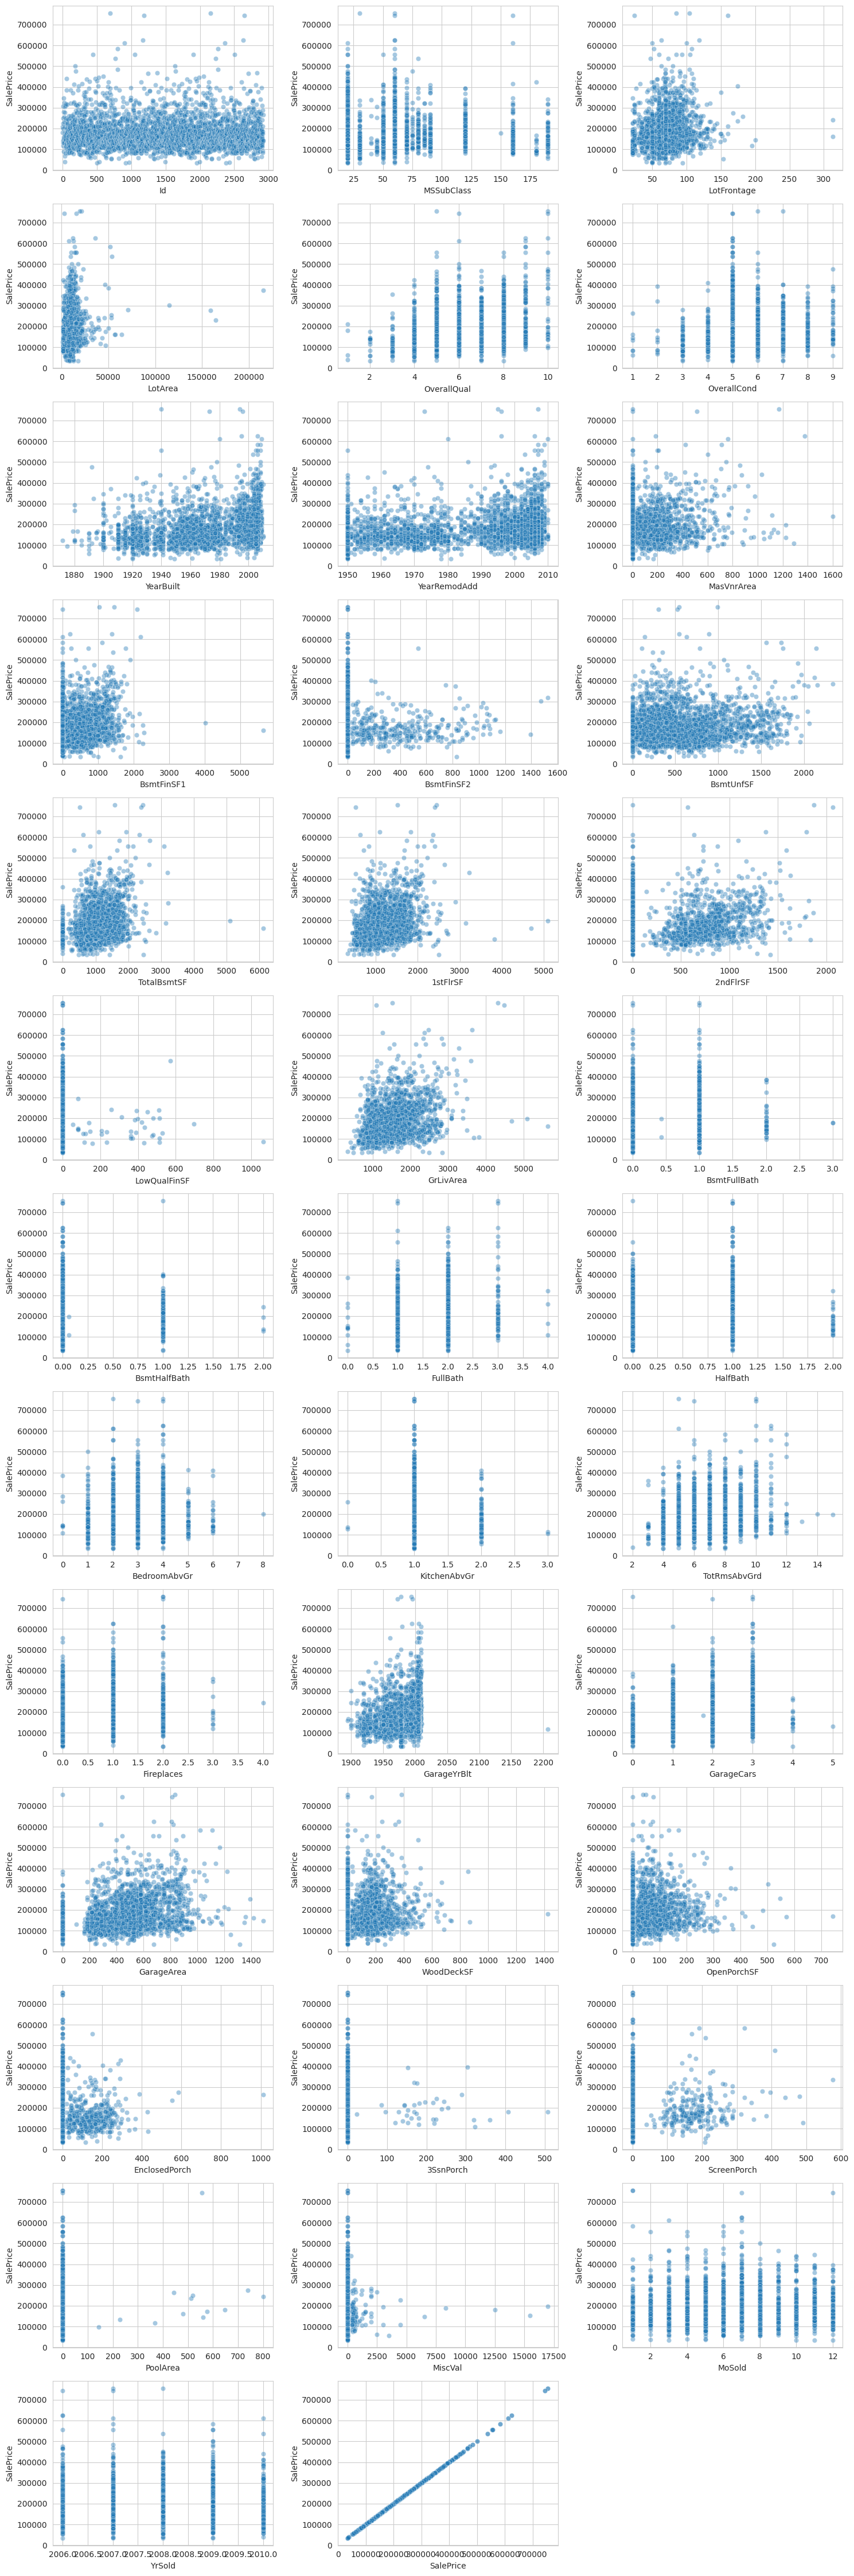

In [ ]:
# Scatter Plot による数値カラムの可視化
sns.set_style("whitegrid")
plt.figure(figsize=(15, 45))

for i, col in enumerate(num_cols, 1):
    plt.subplot(13, 3, i)
    sns.scatterplot(data=df, x=col, y="SalePrice", alpha=0.4)

plt.tight_layout()
plt.show()

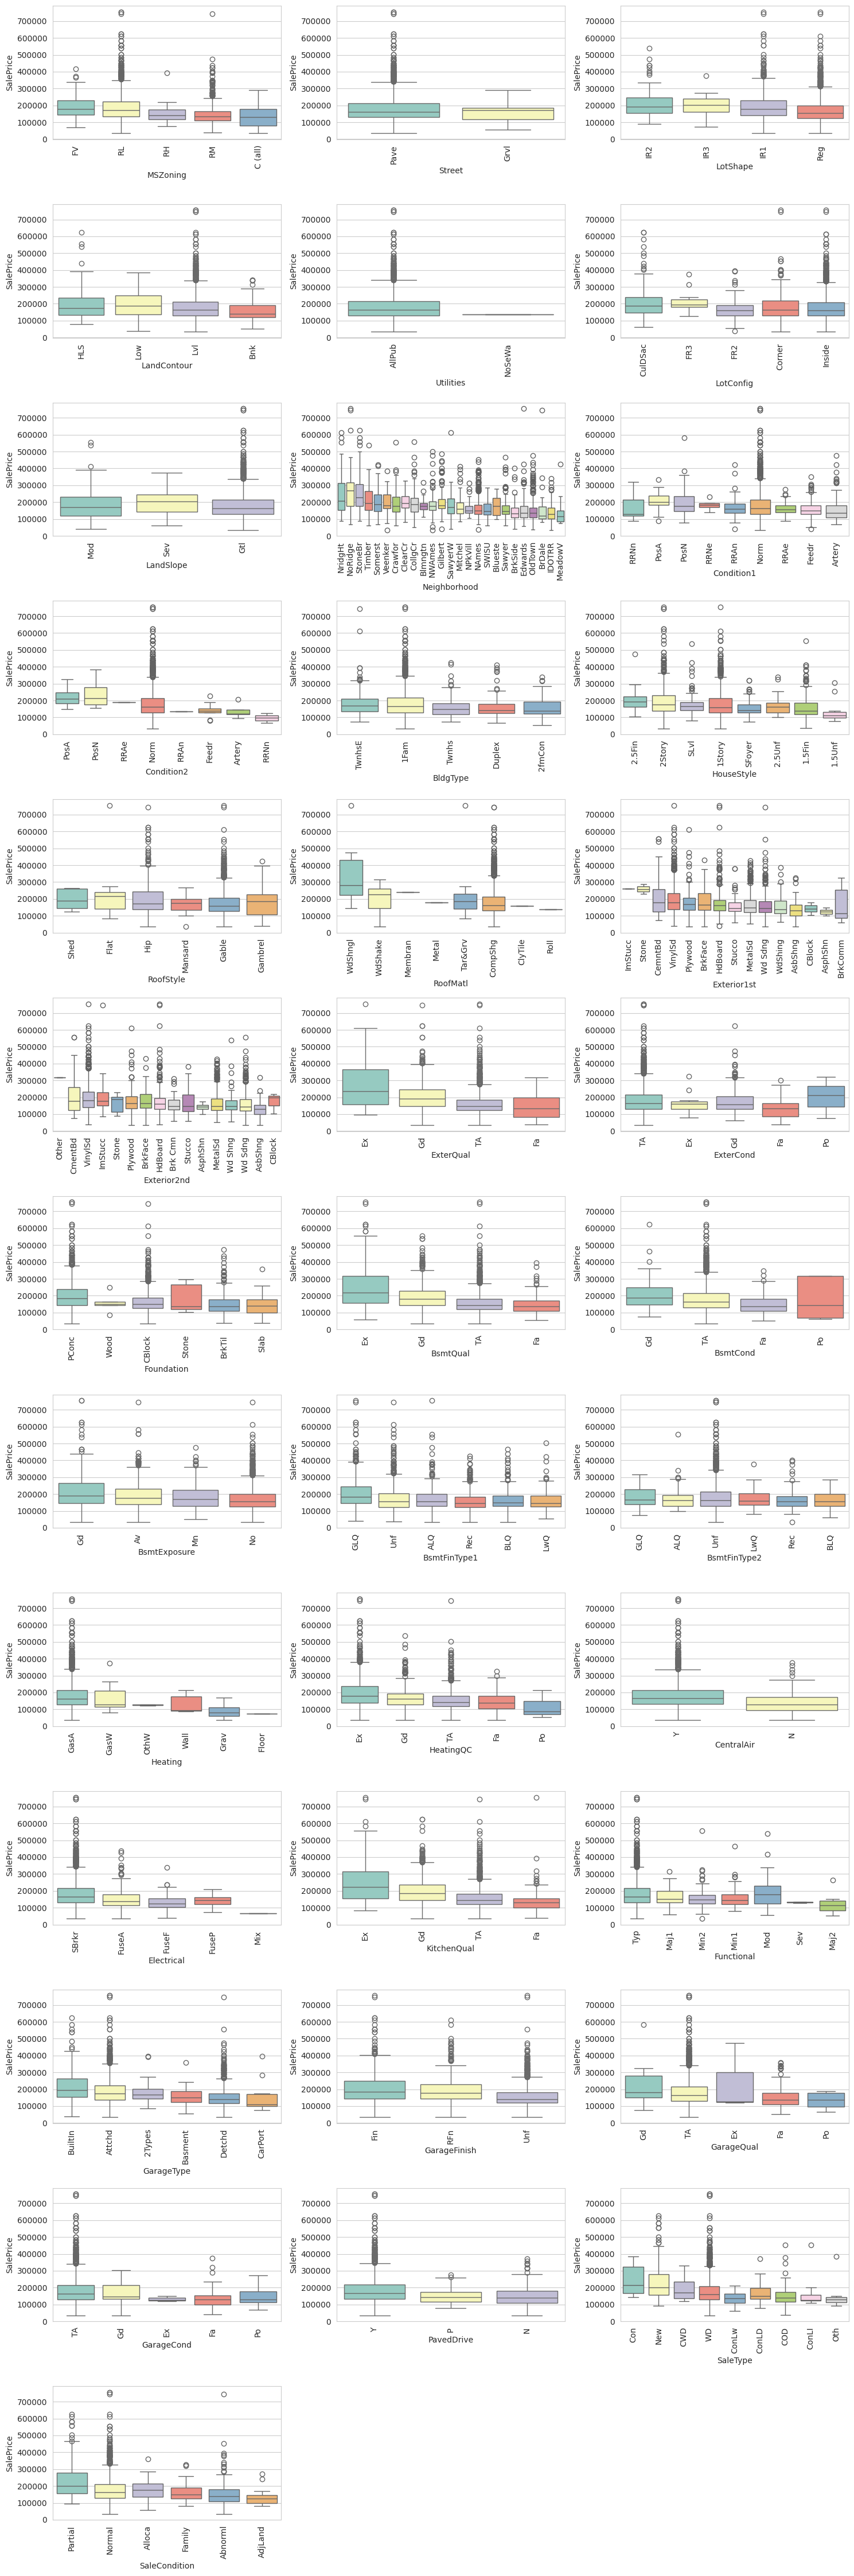

In [ ]:
# Box Plot によるオブジェクト型カラムの可視化
sns.set_style("whitegrid")
plt.figure(figsize=(15, 45))

for i, col in enumerate(cat_cols, 1):
    order=df.groupby(col)["SalePrice"].median().sort_values(ascending=False).index
    plt.subplot(13, 3, i)
    sns.boxplot(data=df, x=col, y="SalePrice", palette="Set3", order=order)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

#### 可視化から得られた気づき

- 数値×数値は **scatter plot**、カテゴリ×数値は **box plot** によって可視化を実施。
- 可視化の結果、数値カラムの **外れ値** がかなり目立つカラムが多数存在することを確認。
- **スケーリング** による数値カラムの外れ値の緩和を今後検討すべきと判断。
- カラム同士に明確な強相関は少ないものの、**軽度な相関** が広く分布している印象。

#### 数値カラムのスケーリング(log1p変換)

In [ ]:
# df[num_cols] = np.log1p(df[num_cols])

#### 数値カラムのスケーリング(Yeo-Johnson変換)


In [ ]:
pt = PowerTransformer(method="yeo-johnson")
df[num_features] = pt.fit_transform(df[num_features])

In [ ]:
y_pt = PowerTransformer(method="yeo-johnson")
df["SalePrice"] = y_pt.fit_transform(df[["SalePrice"]])

#### OneHotEncoding

In [ ]:
# # OneHotEncoding
# df = pd.get_dummies(df, columns=cat_cols)

In [ ]:
# # OneHotEncoding後の要素数確認
# df.shape

#### カテゴリ変数の型変換

In [ ]:
# category型への変換
for col in cat_cols:
    df[col] = df[col].astype("category")

In [ ]:
# 型の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             2919 non-null   float64 
 1   MSSubClass     2919 non-null   float64 
 2   MSZoning       2919 non-null   category
 3   LotFrontage    2919 non-null   float64 
 4   LotArea        2919 non-null   float64 
 5   Street         2919 non-null   category
 6   LotShape       2919 non-null   category
 7   LandContour    2919 non-null   category
 8   Utilities      2919 non-null   category
 9   LotConfig      2919 non-null   category
 10  LandSlope      2919 non-null   category
 11  Neighborhood   2919 non-null   category
 12  Condition1     2919 non-null   category
 13  Condition2     2919 non-null   category
 14  BldgType       2919 non-null   category
 15  HouseStyle     2919 non-null   category
 16  OverallQual    2919 non-null   float64 
 17  OverallCond    2919 non-null   float64

#### 特徴量の設定とデータの分割

In [ ]:
# 特徴量の設定
EX_cols = ["SalePrice", "Id"]

FEATURES = [col for col in df.columns if col not in EX_cols]
TARGET = "SalePrice"

# CatBoostのカテゴリ型変数設定
cat_features = df[FEATURES].select_dtypes(exclude=np.number).columns

# 特徴量の要素数確認
print(df[FEATURES].shape)
print(df[TARGET].shape)

(2919, 73)
(2919,)


In [ ]:
# train と test の分割("SalePrice"がnanであるかどうか)
train = df[df["SalePrice"].notna()]
test = df[df["SalePrice"].isna()]

# train と test の要素数の確認
print(train.shape)
print(test.shape)

(1460, 75)
(1459, 75)


### ◆ 学習ループ(勾配ブースティングモデル)

In [ ]:
# ハイパーパラメータの設定
FOLDS = 5
seed = 42

# 交差検証の設定
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=seed)

In [ ]:
# 変数の設定
RMSE_total = []
R2_total = []
imp = pd.DataFrame()
models = []

# 交差検証による学習ループ
for fold, (train_idx, valid_idx) in enumerate(cv.split(train)):
    print("#"*40)
    print(f"### [FOLD {fold+1}/{FOLDS}]")
    print(f"### train idx: {len(train_idx)}, valid idx: {len(valid_idx)}")
    print("#"*40)

    # データの分割
    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx, TARGET]
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, TARGET]

    # Poolの設定
    train_pool = Pool(X_train, y_train, cat_features=cat_features.tolist())
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features.tolist())



    # モデルの初期化
    ## RandomForestRegressor
    # model = RandomForestRegressor(
    #     random_state=seed
    # )

    ## LGBMRegressor
    # model = LGBMRegressor(
    #     random_state=seed,
    #     verbose=-1,
    # )

    # model = LGBMRegressor(
    #     random_state=seed,
    #     verbose=-1,
    #     learning_rate=0.03,
    #     n_estimators=3000,
    #     colsample_bytree=0.8,
    #     subsample=0.8,
    #     subsample_freq=5,
    # )

    # CatBoostRegressor
    model = CatBoostRegressor(
        random_seed=seed,
        verbose=100,
        use_best_model=True
    )

    # model = CatBoostRegressor(
    #     random_seed=seed,
    #     verbose=100,
    #     use_best_model=True,
    #     iterations=10000,
    #     learning_rate=0.03,
    #     depth=7,
    #     l2_leaf_reg=9,
    #     subsample=0.8,
    #     colsample_bylevel=0.8,
    #     random_strength=1.0,
    #     bagging_temperature=1.0,
    #     border_count=128,
    #     early_stopping_rounds=300,
    # )



    # モデルの学習
    # model.fit(X_train, y_train)

    # model.fit(
    #     X_train, y_train,
        # eval_set=[(X_valid, y_valid)],
        # callbacks=[
        #     lgb.early_stopping(stopping_rounds=100),
        #     lgb.log_evaluation(100)
        # ]
    # )

    model.fit(
        train_pool,
        eval_set=valid_pool,
    )



    # 予測の出力
    y_pred = model.predict(X_valid)

    # 評価の表示
    rmse = root_mean_squared_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)

    # 評価・モデルの追加
    RMSE_total.append(rmse)
    R2_total.append(r2)
    models.append(model)

    # 特徴量重要度の作成・結合
    _imp = pd.DataFrame({
        "feature": FEATURES,
        "importance": model.feature_importances_
    })
    imp = pd.concat([imp, _imp])

    print(f"RMSE: {rmse:.4f}, R2: {r2:.4f}")
    print()

########################################
### [FOLD 1/5]
### train idx: 1168, valid idx: 292
########################################
Learning rate set to 0.052178
0:	learn: 0.9445715	test: 1.0530144	best: 1.0530144 (0)	total: 88.5ms	remaining: 1m 28s
100:	learn: 0.2800208	test: 0.3730543	best: 0.3730543 (100)	total: 4.66s	remaining: 41.5s
200:	learn: 0.2355269	test: 0.3489650	best: 0.3489650 (200)	total: 7.57s	remaining: 30.1s
300:	learn: 0.2051733	test: 0.3392642	best: 0.3392377 (293)	total: 10.6s	remaining: 24.6s
400:	learn: 0.1803349	test: 0.3347439	best: 0.3346707 (374)	total: 18.7s	remaining: 27.9s
500:	learn: 0.1623654	test: 0.3315886	best: 0.3314156 (498)	total: 25.7s	remaining: 25.6s
600:	learn: 0.1483287	test: 0.3306499	best: 0.3306164 (591)	total: 31.9s	remaining: 21.2s
700:	learn: 0.1362001	test: 0.3298890	best: 0.3298890 (700)	total: 36s	remaining: 15.4s
800:	learn: 0.1255716	test: 0.3299327	best: 0.3294748 (748)	total: 40.6s	remaining: 10.1s
900:	learn: 0.1144880	test: 0.3

In [ ]:
RMSE_array = np.array(RMSE_total)
R2_array = np.array(R2_total)

print(f"RMSE: {RMSE_array.mean():.4f} +- {RMSE_array.std():.4f}, R2: {R2_array.mean():.4f} +- {R2_array.std():.4f}")

RMSE: 0.3170 +- 0.0366, R2: 0.8967 +- 0.0276


In [ ]:
imp_df = imp.groupby("feature")["importance"].agg(["mean", "std"]).sort_values(by="mean", ascending=False)
imp_df.head(20)

,mean,std
feature,,
OverallQual,16.350091,2.162204
GrLivArea,15.293879,1.897052
TotalBsmtSF,5.829311,0.738317
BsmtFinSF1,3.665797,0.689308
ExterQual,3.663653,1.894216
KitchenQual,3.599853,1.140679
Fireplaces,3.462309,0.496719
LotArea,3.301892,0.261772
1stFlrSF,3.279394,1.080212


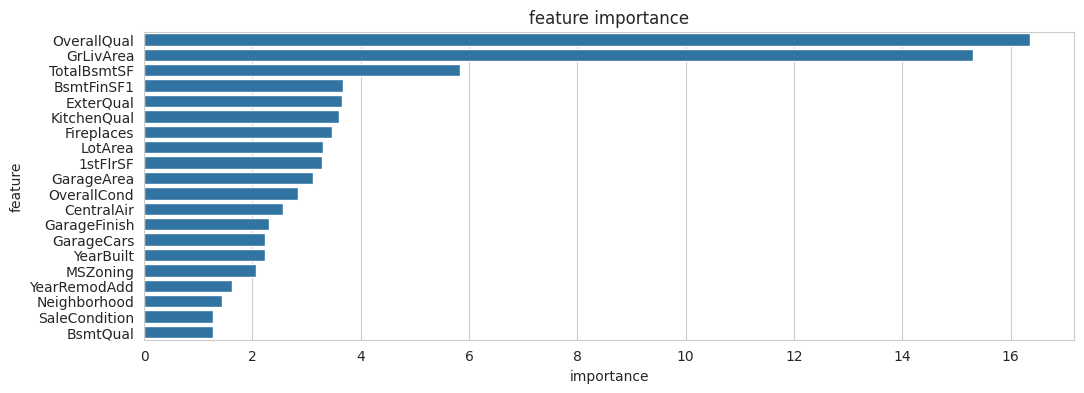

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 4))
sns.barplot(x=imp_df["mean"].head(20), y=imp_df.index[:20])
plt.title("feature importance")
plt.xlabel("importance")
plt.ylabel("feature")
plt.show()

### ◆ 提出データの作成

In [ ]:
# 単一モデルアンサンブルの予測出力の定義
def models_predict(X_test, models):
    print(f"n_models: {len(models)}")
    preds = []

    for model in models:
        pred = model.predict(X_test)
        preds.append(pred)

    preds = np.array(preds)
    preds = np.mean(preds, axis=0)

    return preds

In [ ]:
# 単一モデルアンサンブルの予測出力
pred = models_predict(test[FEATURES], models)

n_models: 5


In [ ]:
# # 予測のスケーリング(log1p変換 => expm1変換)
# pred = np.expm1(pred)

In [ ]:
# 予測のスケーリング(Yeo-Johnson変換)
pred = y_pt.inverse_transform(pred.reshape(-1, 1))

In [ ]:
# 提出ファイルの作成
# submit = pd.DataFrame({
#     "Id": submission["Id"],
#     "SalePrice": pred
# })
submit = pd.DataFrame({
    "Id": submission["Id"],
    "SalePrice": pred.reshape(-1)
})

In [ ]:
# 提出ファイルの保存
# save_path = output_path / "submission.csv"
# save_path = output_path / "submission_LightGBM.csv"
save_path = output_path / "submission_CatBoost.csv"

submit.to_csv(save_path, index=False)

*最終Public Score: 0.12329 (406位 / 4134人中)*


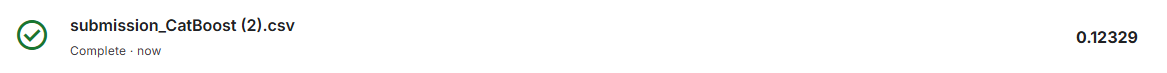

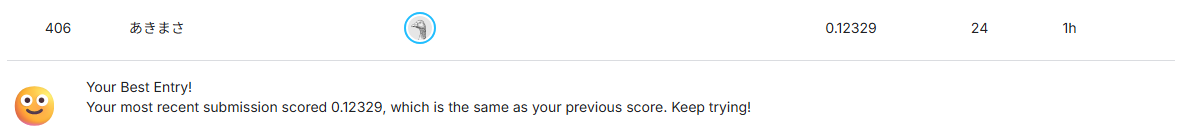

## 〇 モデル精度向上の軌跡

**Baseline**  
- **RandomForestRegressor** による初期モデル構築  
=> *Public Score: 0.14767*

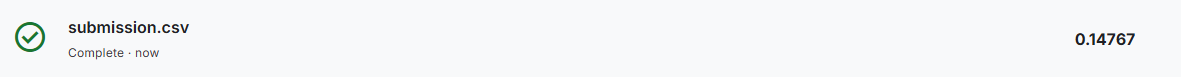

**Step1: モデル変更による精度改善**  
- モデルを **LightGBMRegressor** に変更  
=> シンプルなモデル変更のみで **大幅なスコア改善** を確認  
=> *Public Score: 0.13183*

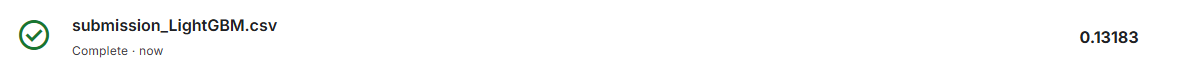

**Step2: 数値変数のスケーリングによる分布の調整(対数変換)**  
- 数値カラムの中に、値のスケールが極端に異なるものが多く存在していたため、  
**log1pによるスケーリング** を適用  
=> 多少なスコア改善 を確認  
=> *Public Score: 0.12978*

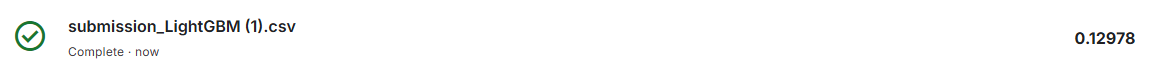

**Step3: スケーリング手法の比較(Yeo-Johnson)**  
- log1pよりも柔軟な分布変換が可能な **Yeo-Johnson変換** を適用  
=> さらに 多少なスコア改善 を確認  
=> *Public Score: 0.12922*

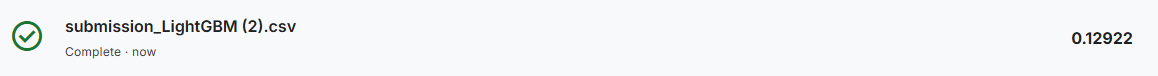

**Step4: カテゴリ変数の型変換(astype("category"))**  
- カテゴリ変数を OneHotEncode ではなく、LightGBMRegressorに最適な **category型** に変換   
=> LightGBMRegressorに適した型に変更することで、スコアが大きく改善   
=> *Public Score: 0.12836*

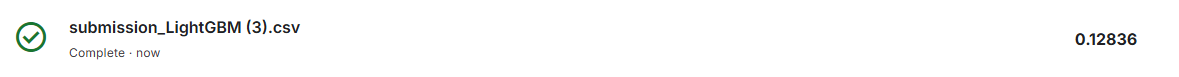

**Step5: ハイパーパラメータの調整**  
- さらなる精度向上を目指して、LightGBMRegressorのハイパーパラメータをチューニング  
=> しかし、調整後のモデルは精度が低下  
=> *Public Score: 0.12885*  

- 結果的に、**デフォルト設定が最も良好** であったため無調整に戻した   
- カテゴリ変数が多いため、**CatBoostRegressor** の検討

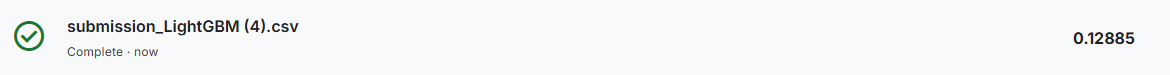

**Step6: モデル変更による精度改善**  
- モデルを **CatBoostRegressor** に変更  
=> シンプルなモデル変更のみで **大幅なスコア改善** を確認  
=> *Public Score: 0.12329*

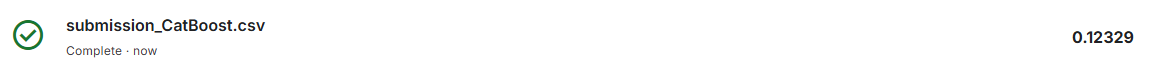

**Step7: ハイパーパラメータの調整**  
- さらなる精度向上を目指して、CatBoostRegressorのハイパーパラメータをチューニング  
=> しかし、調整後のモデルは精度が低下  
=> *Public Score: 0.12473*  

- 結果的に、**デフォルト設定が最も良好** であったため無調整に戻した   

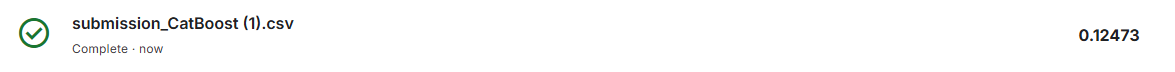

## 〇 まとめ

本ノートブックでは、  
Kaggleコンペティション「**House Prices - Advanced Regression Techniques**」において、  
前回ノートブック「Baseline.ipynb」をベースに、  
**勾配ブースティングモデル** と **交差検証(KFold)** を用いた最終機械学習モデルの構築を行いました。  

本検証では、以下のようなステップで精度向上を図りました。  
- **LightGBM** の導入
- 可視化による分析方針の決定
- 数値カラムの **スケーリング(log1p, yeo-johnson)** による外れ値の緩和
- オブジェクト型変数の **category型** への変換  
- さらなる精度改善を目的とした、**CatBoostRegressor** の導入
- デフォルト設定が最良だったため、パラメータを調整せずに採用  

その結果、**Public Score 0.12329** を記録し、  
全体 **4134人中、上位10%(406位)** にランクインすることができました！！



---
今後も試行錯誤を重ねながら、実践的なスキルを身に着けていきます。  
ここまでご覧いただき、誠にありがとうございました。  